<a href="https://colab.research.google.com/github/ngonhan2k5/cs-ml/blob/master/proj3/notebook/DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [22]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os.path
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

# **1. Settings**

In [23]:
INPUT_SHAPE= (224, 224, 3)
NUM_CLASSES= 2
LAYER_UNITS = () #64, 16
MODEL_FILEPATH= '../models/DENSENET121_model.h5'

train_path = './data/cats-and-dogs/train'
valid_path = './data/cats-and-dogs/valid'
test_path = './data/cats-and-dogs/test'

#**2. Data preparation**

The images included in the data/cats-and-dogs directory are a random subset of the full cat and dog data set from the following Kaggle competition:
https://www.kaggle.com/c/dogs-vs-cats/data

In [24]:
train_batches = ImageDataGenerator().flow_from_directory(directory=train_path, target_size=(224,224), classes=['dog', 'cat'], batch_size=10)
valid_batches = ImageDataGenerator().flow_from_directory(directory=valid_path, target_size=(224,224), classes=['dog', 'cat'], batch_size=4)
test_batches = ImageDataGenerator().flow_from_directory(directory=test_path, target_size=(224,224), classes=['dog', 'cat'], batch_size=10)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [25]:
# assert train_batches.n == 40
# assert valid_batches.n == 16
# assert test_batches.n == 10
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

In [26]:
# plots images with labels within jupyter notebook
# source: https://github.com/fastai/courses/blob/master/deeplearning1/nbs/utils.py#L79

def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

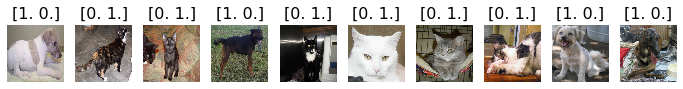

In [27]:
imgs, labels = next(train_batches)
plots(imgs, titles=labels)

#**3. DenseNet121 model**

###3.1. Build Model
- Transfer Learning
- Save the builded model for the next time using

In [28]:
def build_model(base_model, layer_units):
  model= Sequential()
  model.add(base_model)
  #freeze model
  for layer in model.layers:
      layer.trainable = False

  model.add(Flatten())
  for num_units in layer_units:
        model.add(Dense(num_units, activation='relu'))
  model.add(Dense(units=NUM_CLASSES, activation='softmax'))
  return model

In [29]:
if os.path.isfile(MODEL_FILEPATH) is True:
  model= load_model(MODEL_FILEPATH)
else:  
  # Download DenseNet121 model - Internet connection needed
  denseNet_model= tf.keras.applications.DenseNet121(
    include_top=False,#without classifier layer
    weights="imagenet",
    input_shape= INPUT_SHAPE
  )

  # Transfer learning DenseNet121 model
  model= build_model(denseNet_model, LAYER_UNITS)
  model.summary()

  #Compile model
  model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


##3.2. Train model

In [30]:
history = model.fit(x=train_batches, steps_per_epoch=4, 
                    validation_data=valid_batches, validation_steps=4, epochs=10, verbose=2)

Train for 4 steps, validate for 4 steps
Epoch 1/10
4/4 - 16s - loss: 0.6001 - accuracy: 0.8000 - val_loss: 4.4224 - val_accuracy: 0.6250
Epoch 2/10
4/4 - 7s - loss: 0.3192 - accuracy: 0.9250 - val_loss: 1.4164 - val_accuracy: 0.5625
Epoch 3/10
4/4 - 6s - loss: 0.2594 - accuracy: 0.9250 - val_loss: 1.5199 - val_accuracy: 0.6875
Epoch 4/10
4/4 - 7s - loss: 0.3381 - accuracy: 0.8500 - val_loss: 1.5914 - val_accuracy: 0.6250
Epoch 5/10
4/4 - 7s - loss: 0.1671 - accuracy: 0.9250 - val_loss: 5.7023 - val_accuracy: 0.5625
Epoch 6/10
4/4 - 7s - loss: 0.3197 - accuracy: 0.8750 - val_loss: 6.9412 - val_accuracy: 0.5625
Epoch 7/10
4/4 - 7s - loss: 0.4598 - accuracy: 0.8250 - val_loss: 5.7247 - val_accuracy: 0.5625
Epoch 8/10
4/4 - 7s - loss: 0.3666 - accuracy: 0.9250 - val_loss: 1.3052 - val_accuracy: 0.6875
Epoch 9/10
4/4 - 7s - loss: 0.1484 - accuracy: 0.9250 - val_loss: 1.8164 - val_accuracy: 0.7500
Epoch 10/10
4/4 - 7s - loss: 0.2911 - accuracy: 0.8750 - val_loss: 1.1599 - val_accuracy: 0.687

In [31]:
assert model.history.history.get('accuracy')[-1] > 0.85

##3.3. Predict

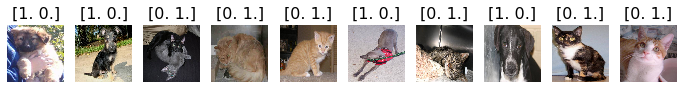

In [32]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

In [33]:
test_labels = test_labels[:,0]
test_labels

array([1., 1., 0., 0., 0., 1., 0., 1., 0., 0.], dtype=float32)

In [34]:
predicted_labels = model.predict(x=test_batches, steps=1, verbose=0)

**Confusion matrix**

In [35]:
cm = confusion_matrix(y_true=test_labels, y_pred=np.round(predicted_labels[:,0]))

In [36]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[5 1]
 [2 2]]


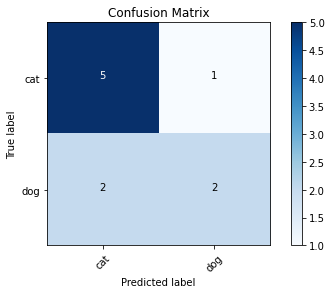

In [37]:
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [38]:
def print_results(cm):
    tp = cm[0, 0]
    tn = cm[1, 1]
    fn = cm[0, 1]
    fp = cm[1, 0]
    
    accuracy = ((tp + tn) / (tp + tn + fp + fn)) * 100    
    sensitivity = (tp / (tp + fn)) * 100    
    specificity = (tn / ( tn + fp )) * 100
    
    precision= tp / (tp+fp) 
    recall= tp / (tp+fn)
    f1= (2 * precision * recall) / (precision + recall) 

    print ('Accuracy: ',  accuracy, "%")
    print ('Sensitivity: ', sensitivity, "%")    
    print ('Specificity: ',  specificity, "%")
    print ('')
    print ('F1 score: ',  round(f1 * 100, 1), "%")
    print ('Precision: ', round(precision * 100, 1), "%")    
    print ('Recall: ',  round(recall * 100, 1), "%")

In [39]:
print_results(cm)

Accuracy:  70.0 %
Sensitivity:  83.33333333333334 %
Specificity:  50.0 %

F1 score:  76.9 %
Precision:  71.4 %
Recall:  83.3 %


##3.4. Loss Curve and Accuracy Curve

In [40]:
def plot_training_curves(history):  
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss,  label='Train')
    plt.plot(epochs, val_loss, label='Test')
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.figure()
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    plt.plot(epochs, acc, label='Train')
    plt.plot(epochs, val_acc, label='Test')
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch') 
    plt.legend()
    plt.figure()
    
    plt.show()

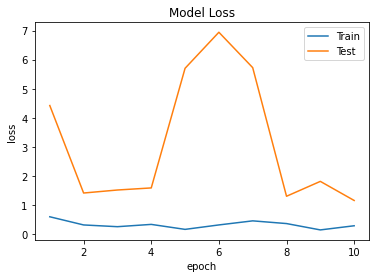

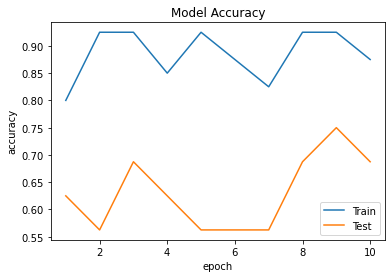

<Figure size 432x288 with 0 Axes>

In [41]:
plot_training_curves(history)

In [42]:
# Save model
if os.path.isfile(MODEL_FILEPATH) is False:
    model.save(MODEL_FILEPATH)